# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd



from droplet_approximation import *
from droplet_approximation.models import *



In [ ]:
# The notebook graphs the "worst" 5% of particle by NRMSE
# These five are picked based on the first model provided
# in `model_load_paths`. Each subsequent model will be evaluated
# on the same data, and will have an NRMSE calculated,
# but they will not be used to determine which particles to graph.

model_load_paths = ["../models/network_box_residual_l1_epoch_5.pth",
                    "../models/network_box_residual_l1_epoch_14.pth"]
testing_data_file = "../data/error_analysis_particles.parquet"

commit_SHAs = ["369bacc0ba5c7367f17ec71707a1df64afd1b6f5",
              "369bacc0ba5c7367f17ec71707a1df64afd1b6f5"]



# Note -    NRMSE is current calculated against BE **NOT** BDF
#           accordingly, whenever there is a BE failure, NRMSE
#           goes up even when the model is doing well. This will
#           be fixed in future versions. Currently, a flag is provided
#           to allow NRMSE to be calculated against BDF instead
#           to measure how well the network is learning the
#           training data.

score_against_BDF = False   # If False, calculate NRMSE against NTLP be data,
                            # If True, calculate NRMSE against BE data

time_range = None           # Set to tuple to graph particle output graphs on
                            # A particle time range. e.g.
#time_range = (50,150)      # Will graph the particle trajectories from t=50 -> t=150

graph_RH = True             # If set to True, graph particle RH as well

In [11]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0].replace("_", " ") for path in model_load_paths]

models = [ResidualNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

In [12]:
df = pd.read_parquet( testing_data_file )

In [13]:
# Calculate NRMSE for each particle
# Perhaps we could write a script to do this en masse on the cluster
nrmse = np.zeros(len(df))
for i in range(len(df)):
    particle_df = df.iloc[i]

    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy(), axis=-1)

    times = np.cumsum(particle_df["integration times"])

    model_output = do_iterative_inference(
                            input_parameters, 
                            times,
                            models[0],
                            "cpu"
                        )


    # For consistency sake calculating NRMSE against BE
    # Currently leads to issues where BE because there is
    # no be flag array, the MLP is scored lower when
    # BE fails. NRMSE can be calculated against BDF instead
    # by setting score_against_BDF to True

    if score_against_BDF:
        truth_output = do_iterative_bdf(
                                input_parameters, 
                                times)
        
        nrmse[i] = calculate_nrmse( model_output, truth_output,  standard_distance  )
    else:
        nrmse[i] = calculate_nrmse( model_output, input_parameters[:, :2], standard_distance  )



In [14]:
df["nrmse"] = nrmse

Trajectory statistics:
max:  [3.7795133e-05 2.9876556e+02 2.2116812e-18 2.9882202e+02 1.0789487e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8896027e+02 2.2116812e-18 2.8856213e+02 1.0028564e+00
 1.0000000e+00]
max:  [ 0.551624    0.8456955  -0.05545044  0.8527527   0.43543157  0.        ]
min:  [-0.9659799  -0.37996674 -0.05545044 -0.42973328 -0.94806594  0.        ]
max tempearture diff:  0.920105
network box residual l1 epoch 5 NRMSE against BE: 0.8313240483403206%
Scoring NRMSE against BE


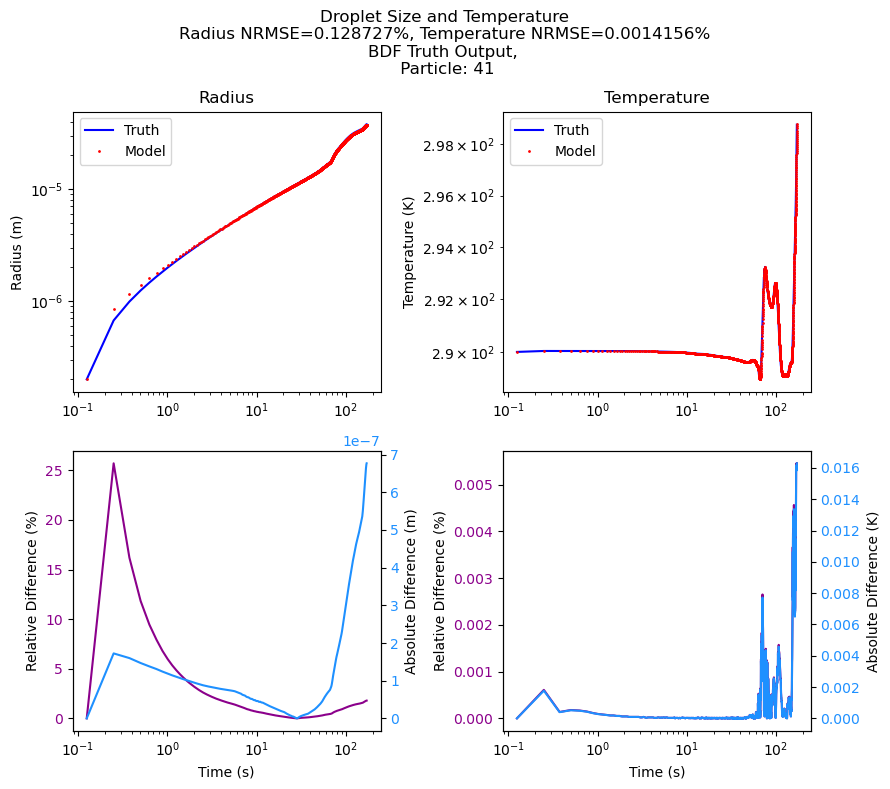

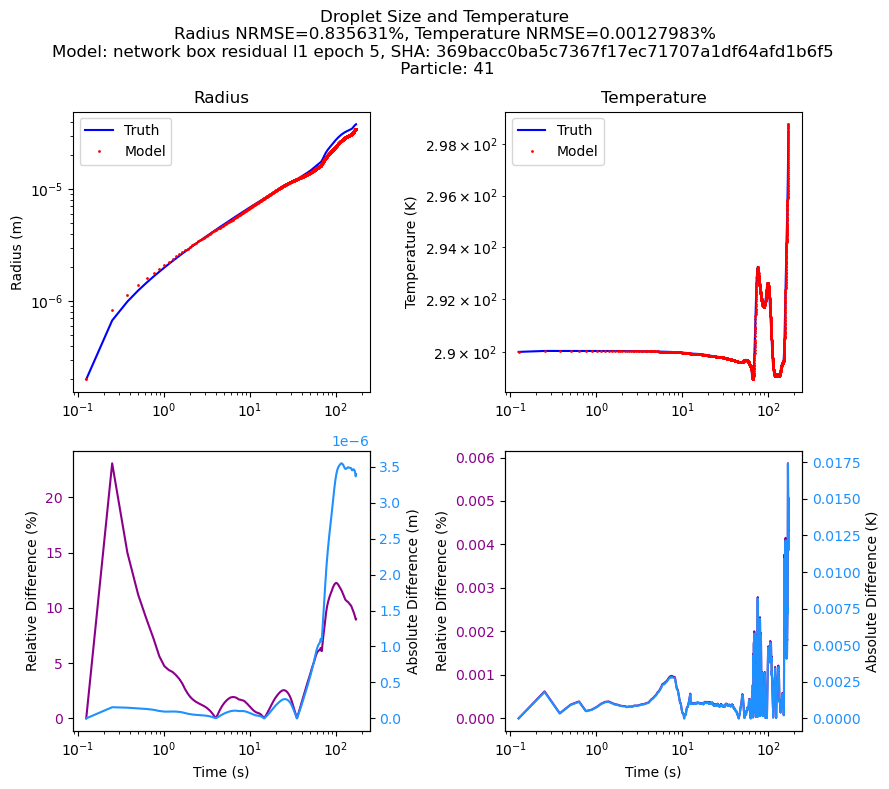

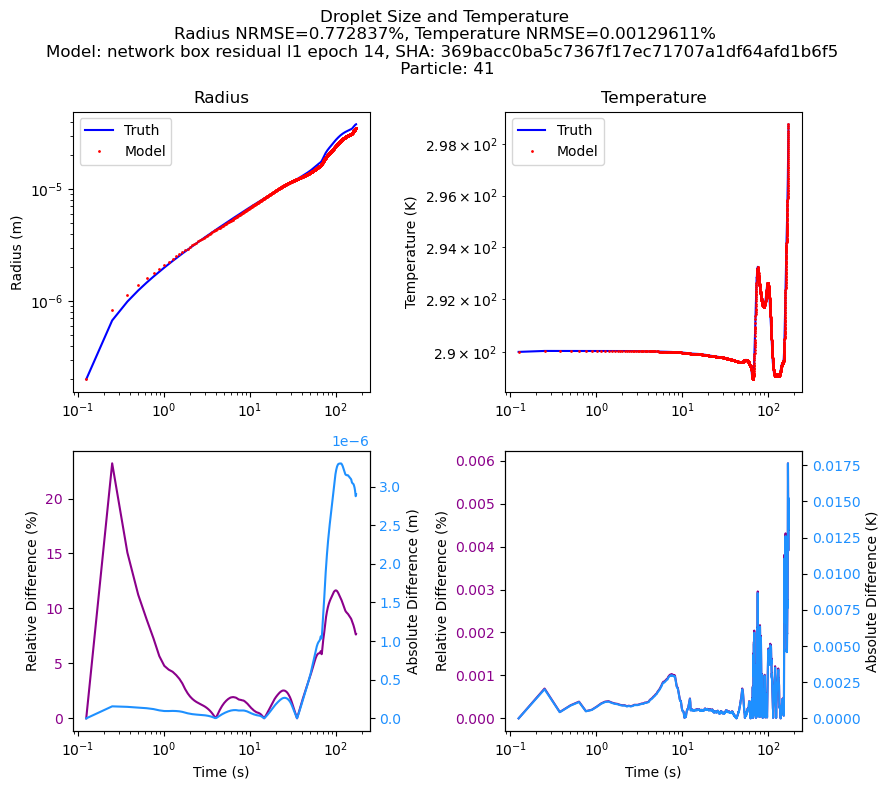

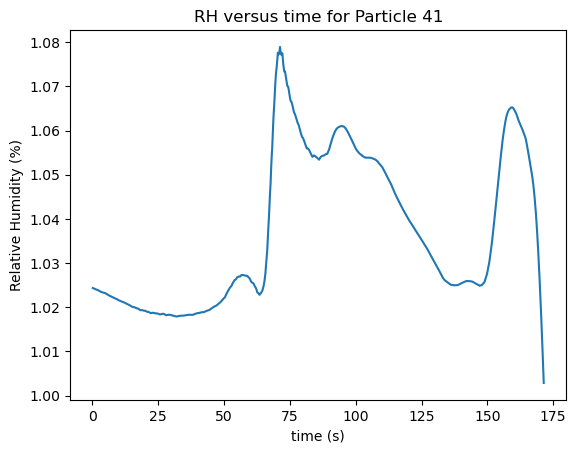

Trajectory statistics:
max:  [3.6794168e-05 2.9865753e+02 2.2116812e-18 2.9872665e+02 1.0758086e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8836777e+02 2.2116812e-18 2.8788312e+02 1.0046550e+00
 1.0000000e+00]
max:  [ 0.5438528   0.83219147 -0.05545044  0.84083176  0.378339    0.        ]
min:  [-0.9659799  -0.45402908 -0.05545044 -0.5146103  -0.91536355  0.        ]
max tempearture diff:  0.9260864
network box residual l1 epoch 5 NRMSE against BE: 0.8421801030635834%
Scoring NRMSE against BE


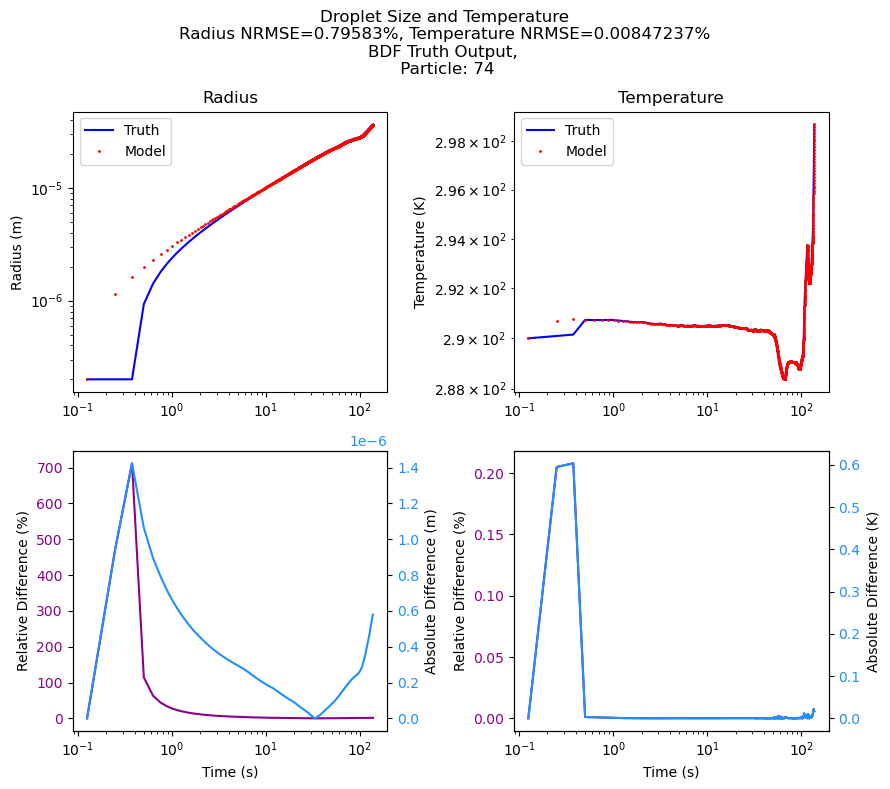

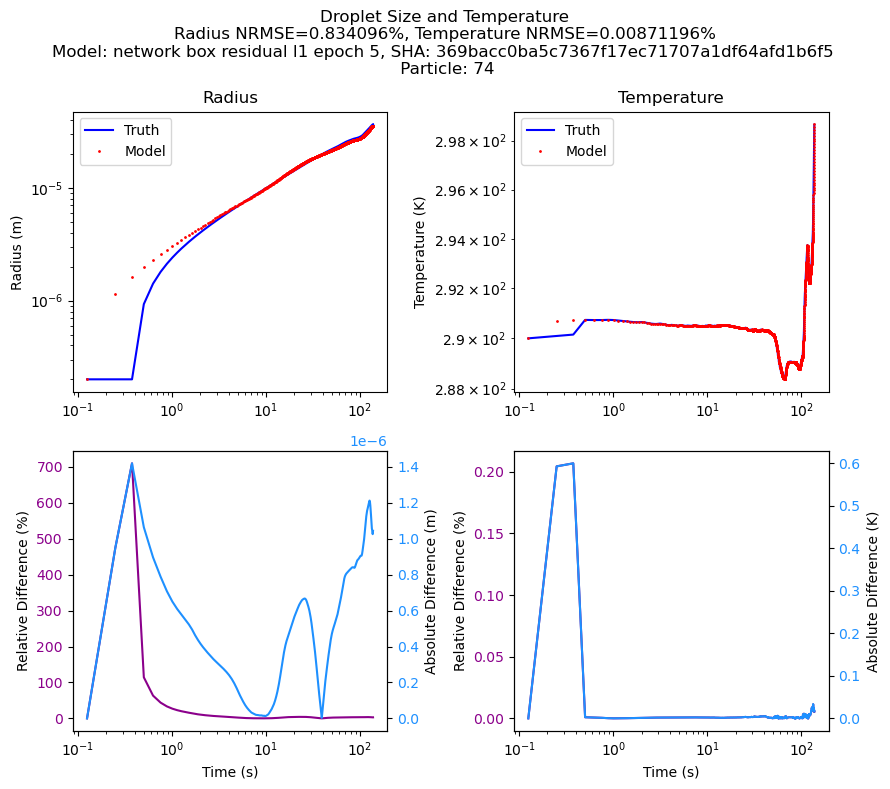

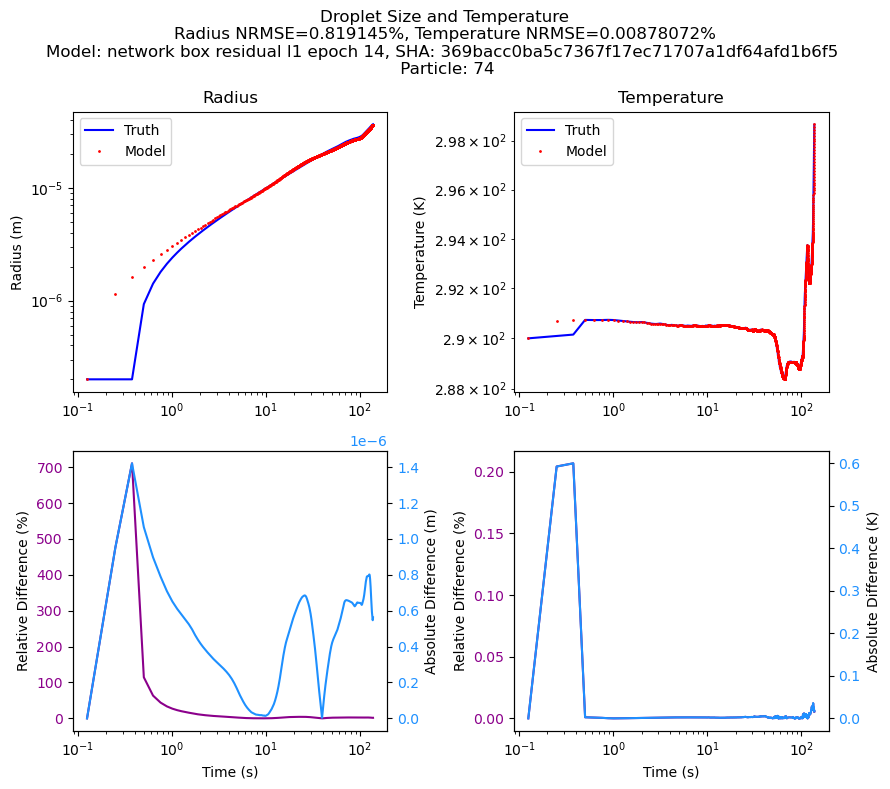

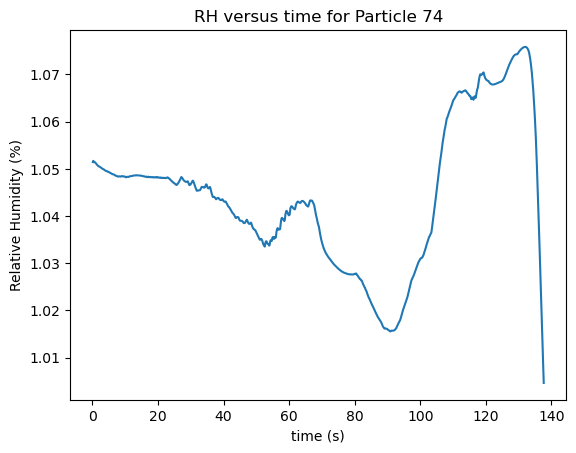

Trajectory statistics:
max:  [3.4316490e-05 2.9857639e+02 2.2116812e-18 2.9864807e+02 1.0914543e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8771942e+02 2.2116812e-18 2.8730441e+02 1.0056981e+00
 1.0000000e+00]
max:  [ 0.5236686   0.8220482  -0.05545044  0.8310089   0.66280484  0.        ]
min:  [-0.9659799  -0.5350723  -0.05545044 -0.5869484  -0.8963985   0.        ]
max tempearture diff:  0.8300781
network box residual l1 epoch 5 NRMSE against BE: 0.8644877932965755%
Scoring NRMSE against BE


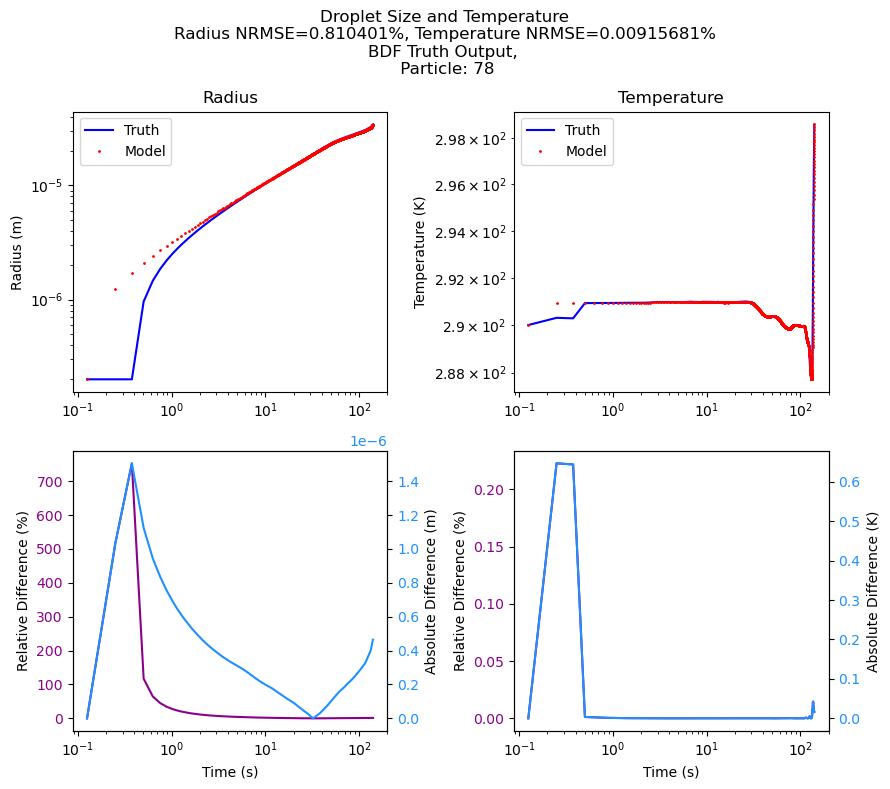

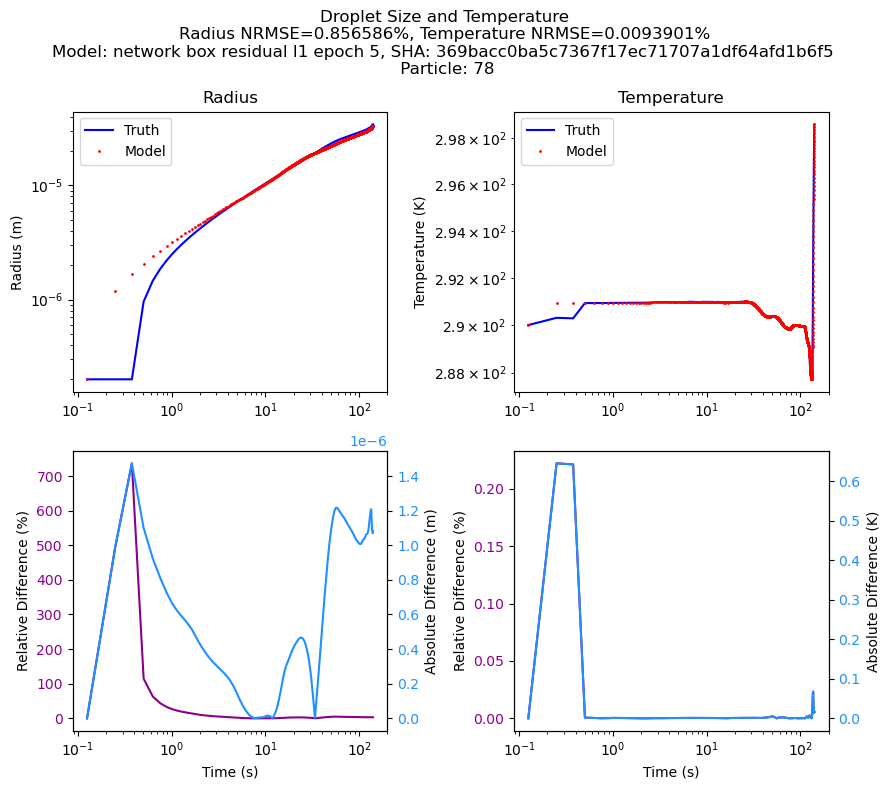

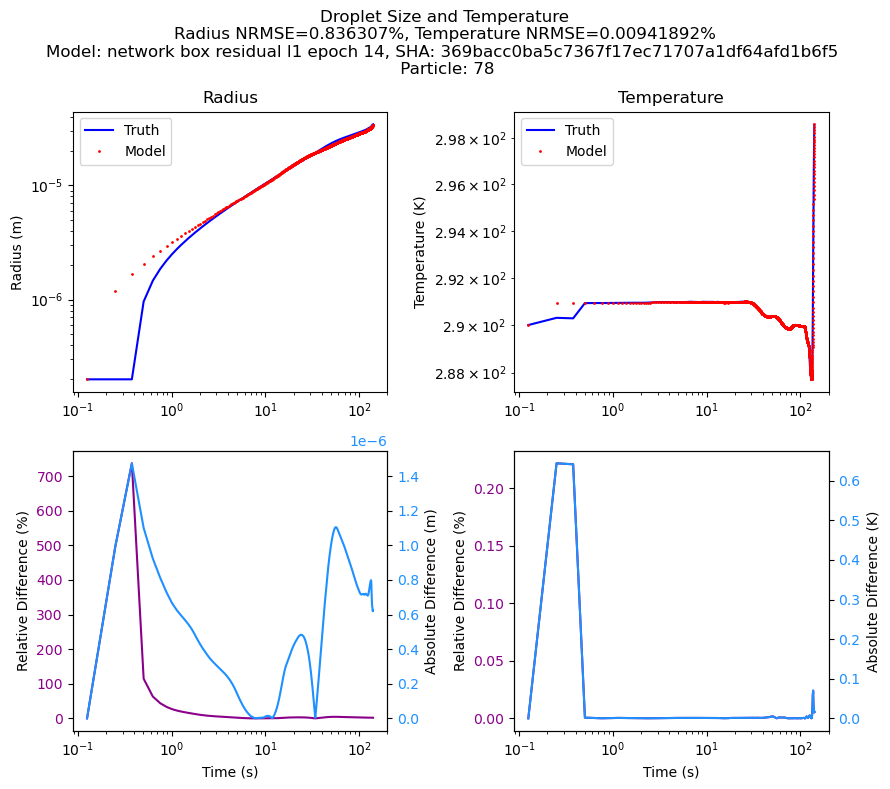

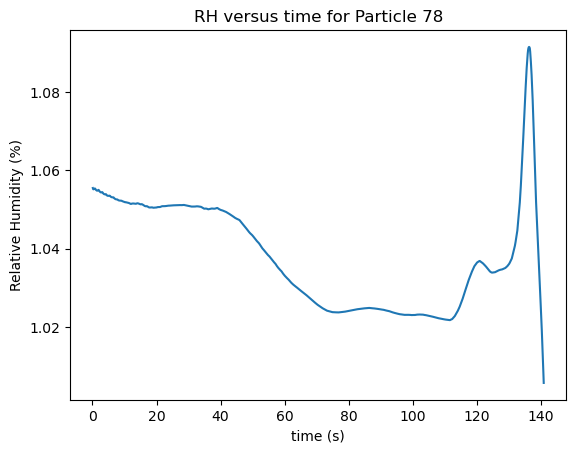

Trajectory statistics:
max:  [3.7017810e-05 2.9870508e+02 2.2116812e-18 2.9879587e+02 1.0800136e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8871393e+02 2.2116812e-18 2.8817899e+02 1.0029528e+00
 1.0000000e+00]
max:  [ 0.54560727  0.83813477 -0.05545044  0.8494835   0.45479333  0.        ]
min:  [-0.9659799  -0.41075897 -0.05545044 -0.4776268  -0.9463125   0.        ]
max tempearture diff:  1.2788391
network box residual l1 epoch 5 NRMSE against BE: 0.74916104786098%
Scoring NRMSE against BE


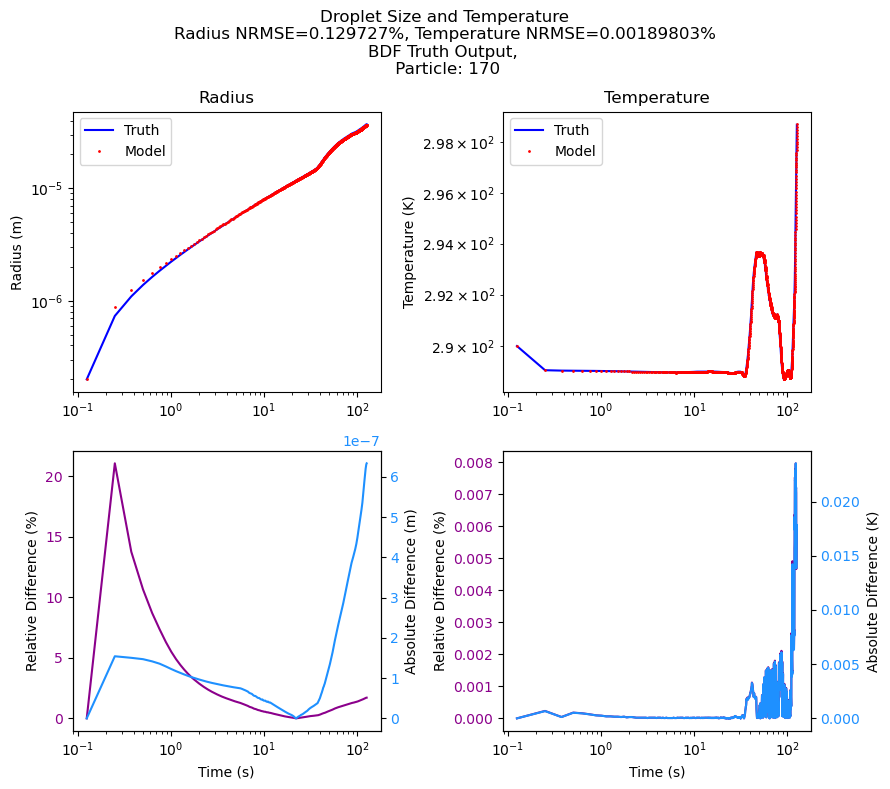

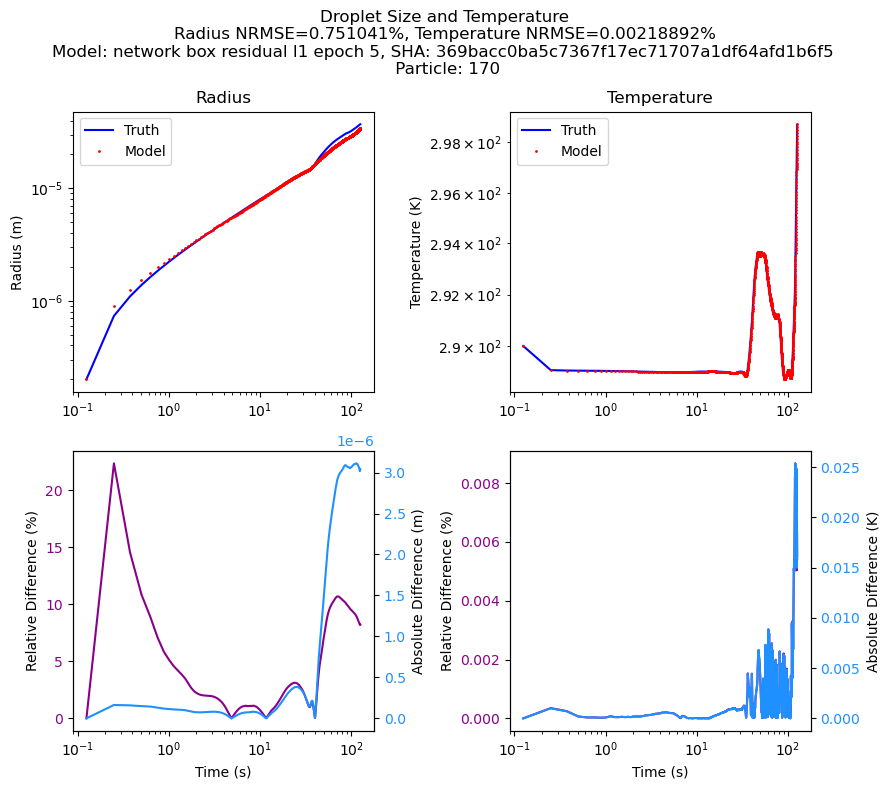

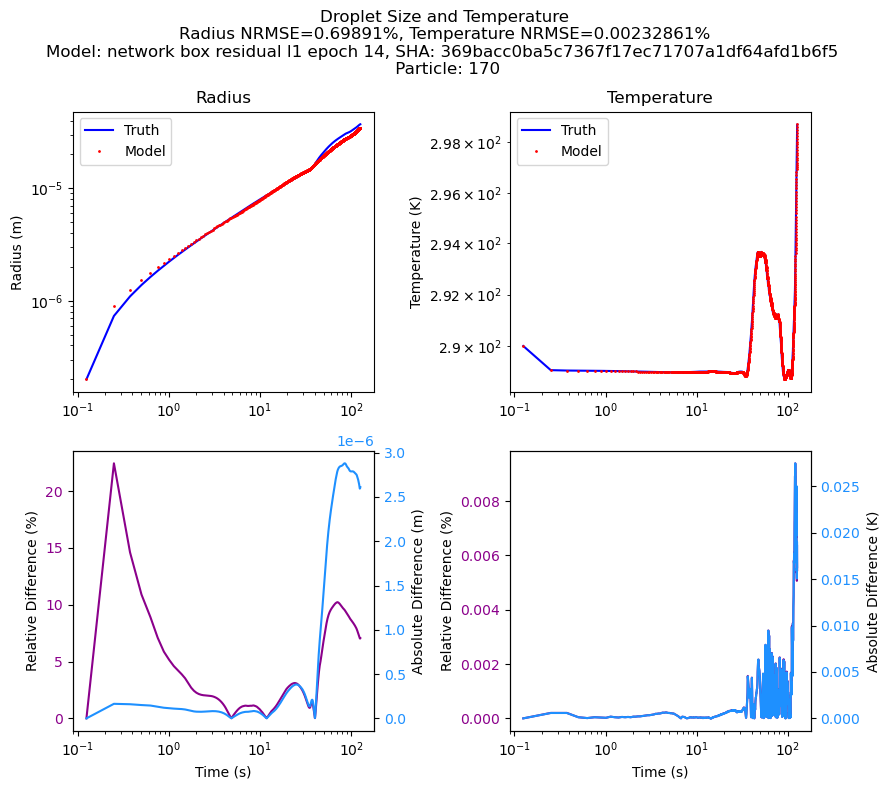

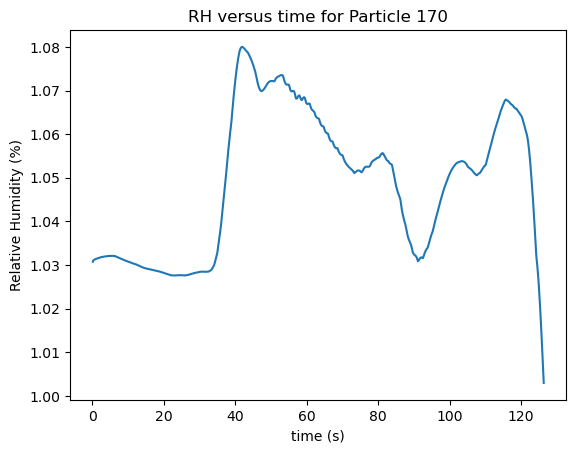

Trajectory statistics:
max:  [4.3010568e-05 2.9802637e+02 2.2116812e-18 2.9811288e+02 1.0828084e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8846930e+02 2.2116812e-18 2.8811261e+02 1.0160286e+00
 1.0000000e+00]
max:  [ 0.58905     0.7532959  -0.05545044  0.76411057  0.50560683  0.        ]
min:  [-0.9659799  -0.4413376  -0.05545044 -0.48592377 -0.7085701   0.        ]
max tempearture diff:  0.92874146
network box residual l1 epoch 5 NRMSE against BE: 0.6786299403756857%
Scoring NRMSE against BE


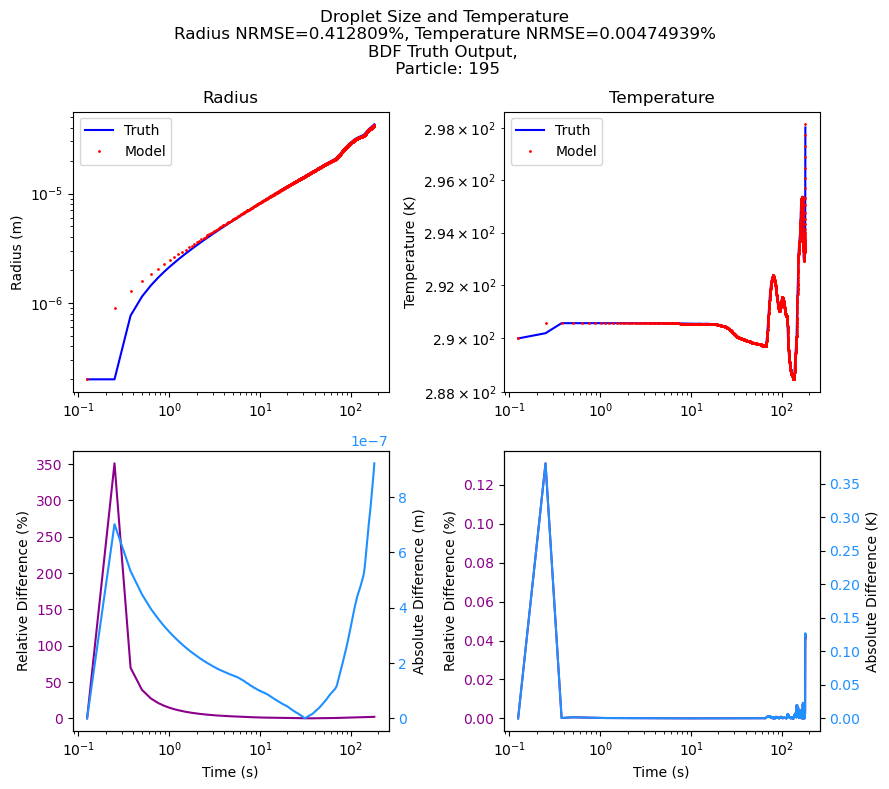

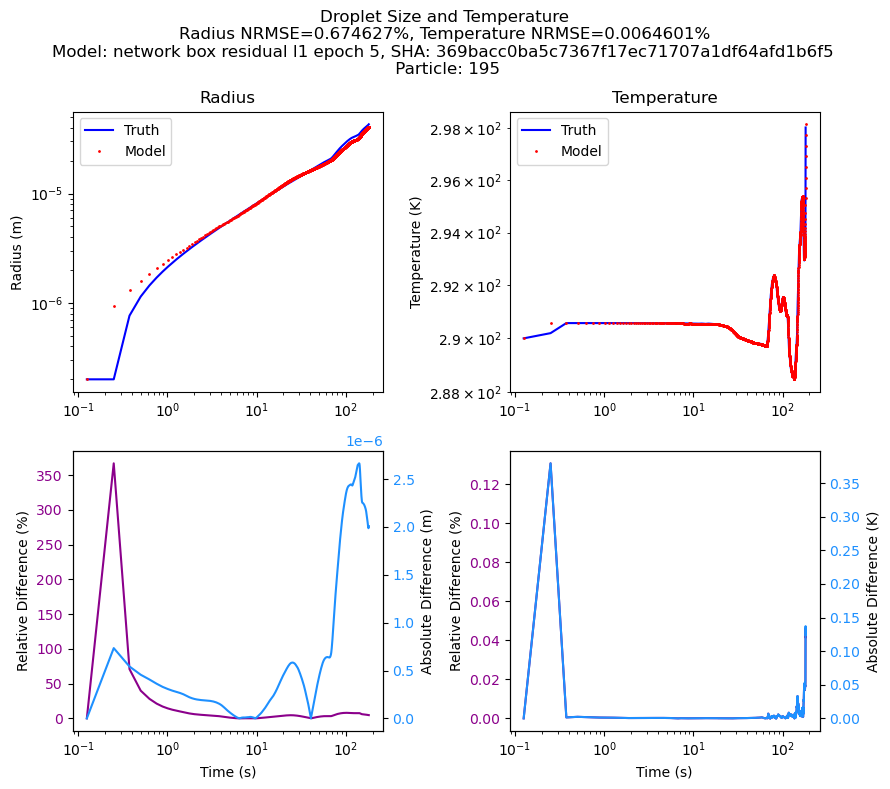

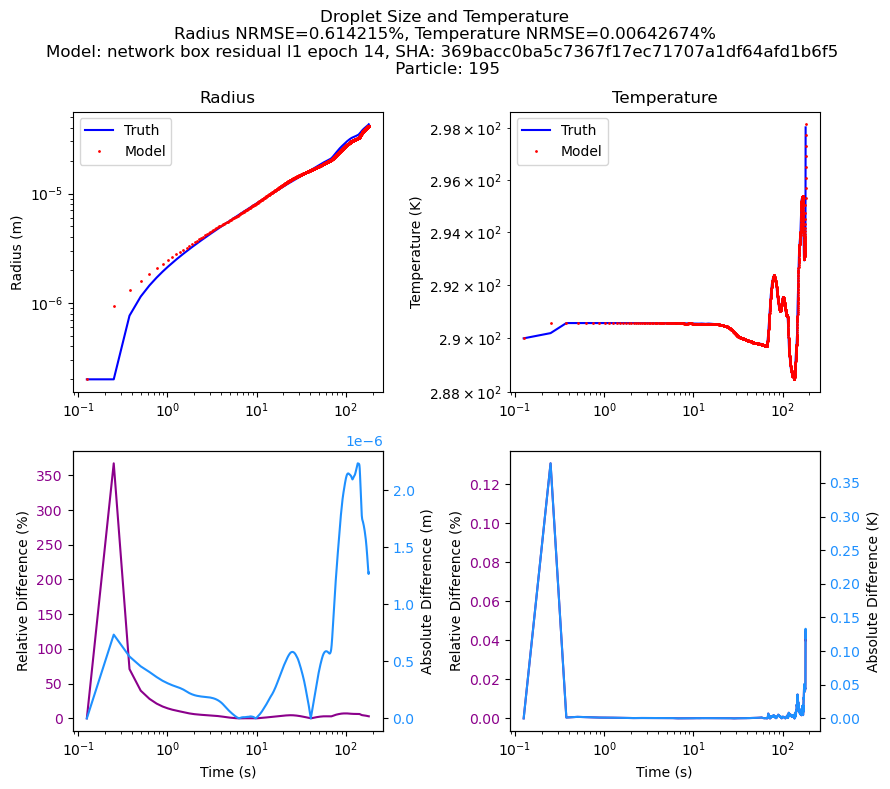

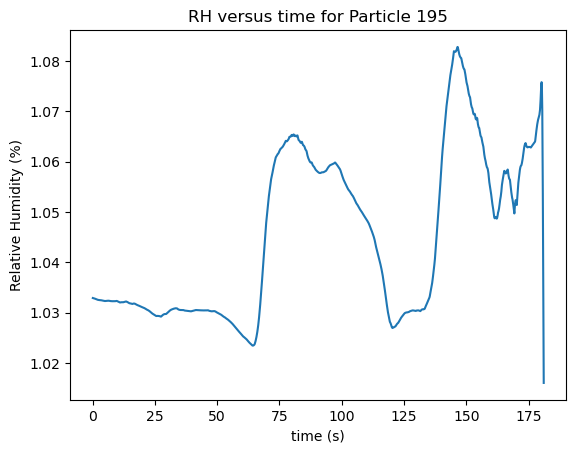

In [15]:
for i in df[(df["nrmse"] >= df["nrmse"].quantile(.95))].index:
    particle_df = df.loc[df.index == i]
    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy()[0], axis=-1)

    print("Trajectory statistics:")
    print("max: ", input_parameters.max(axis=0))
    print("min: ", input_parameters.min(axis=0))
    print("max: ", normalize_droplet_parameters( input_parameters.max( axis=0 ) ) ) 
    print("min: ", normalize_droplet_parameters( input_parameters.min( axis=0) ) )
    print("max tempearture diff: ", (input_parameters[:, 1] - input_parameters[:, 3]).max())
    print("{} NRMSE against BE: {}%".format(model_names[0], particle_df["nrmse"].values[0]*100))

    times = np.cumsum(particle_df["integration times"].to_numpy()[0])
    model_outputs = [ do_iterative_inference(
                            input_parameters, 
                            times,
                            models[i],
                            "cpu"
                        ) for i in range( model_count ) ]
    truth_output = do_iterative_bdf(
        input_parameters,
        times
    )

    if score_against_BDF:
        print("Scoring NRMSE against BDF")
        model_distances = [ standard_distance( truth_output, model_outputs[i] ) for i in range( model_count ) ]
        truth_distance = standard_distance( truth_output, truth_output)
    else:
        print("Scoring NRMSE against BE")
        model_distances = [ standard_distance( input_parameters[:, :2], model_outputs[i] ) for i in range( model_count ) ]
        truth_distance = standard_distance( input_parameters[:, :2], truth_output)


    analyze_model_particle_performance(
        times,
        input_parameters[:, :2], 
        truth_output,
        truth_distance,
        "BDF Truth Output, \n Particle: " + str( i ),
        time_range=time_range
    )
    for j in range( model_count ): 
        analyze_model_particle_performance(
            times,
            input_parameters[:, :2], 
            model_outputs[j],
            model_distances[j],
            "Model: " + model_names[j] + ", SHA: " + commit_SHAs[j] + " \n Particle: " + str( i ),
            time_range=time_range
        )
    if graph_RH:
        plt.figure()
        plt.plot(times, particle_df["relative humidities"].to_numpy()[0])
        plt.title("RH versus time for Particle " + str(i))
        plt.xlabel("time (s)")
        plt.ylabel("Relative Humidity (%)") 
        plt.show()
